#                     BIA660 Final project-Topic detection of customer review on smart home appliances 

In [1]:
#pip install gensim

In [2]:
#pip install pyLDAvis

In [3]:
import nltk, re, json, string
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import defaultdict 
from nltk.corpus import stopwords 
import gensim
from gensim import corpora 
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


### Exploring the data 

In [4]:
df = pd.read_csv('all_Bissell_CrossWave.csv')

In [5]:
df.head()

,Account_name,Score,Title,Location,Date,Product,Purchase_Status,Review_content,Like
0,Cherish Vuyovich,5.0 out of 5 stars,I don't get these bad reviews,the United States,21-Apr-20,CrossWave,Verified Purchase,I am in the process of purchasing this for our...,"2,372"
1,Deb Riester,1.0 out of 5 stars,FATAL design flaw.,the United States,5-Nov-17,CrossWave,Verified Purchase,Excellent idea. Worked fantastic on my polishe...,"6,346"
2,Jackie,1.0 out of 5 stars,Leaves dirty streaks,the United States,23-Dec-17,CrossWave,Verified Purchase,I saved up money and was super excited to orde...,"1,110"
3,Mary,1.0 out of 5 stars,It leaves streaks and doesn’t seem like the sc...,the United States,16-Feb-18,CrossWave,Verified Purchase,Wish i wouldn’t of purchased this floor cleane...,604
4,Nicole Becerra,5.0 out of 5 stars,Review and tips included,the United States,7-May-17,CrossWave,Verified Purchase,Okay so I waited a couple of months to try thi...,"2,619"


In [6]:
df.describe()


,Account_name,Score,Title,Location,Date,Product,Purchase_Status,Review_content,Like
count,7366,7366,7363,7366,7366,7355,6144,7364,2488
unique,6041,5,5795,3,1763,9,1,7258,107
top,Amazon Customer,5.0 out of 5 stars,Five Stars,the United States,27-May-21,CrossWave,Verified Purchase,Love it!,One
freq,662,4445,180,7190,22,4493,6144,16,1269


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7366 entries, 0 to 7365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Account_name     7366 non-null   object
 1   Score            7366 non-null   object
 2   Title            7363 non-null   object
 3   Location         7366 non-null   object
 4   Date             7366 non-null   object
 5   Product          7355 non-null   object
 6   Purchase_Status  6144 non-null   object
 7   Review_content   7364 non-null   object
 8   Like             2488 non-null   object
dtypes: object(9)
memory usage: 518.0+ KB


In [8]:
df.isnull().sum()

Account_name          0
Score                 0
Title                 3
Location              0
Date                  0
Product              11
Purchase_Status    1222
Review_content        2
Like               4878
dtype: int64

In [9]:
len(df)

7366

### Raw data visualization

<Figure size 576x288 with 0 Axes>

(array([4445.,    0., 1138.,    0.,    0.,  831.,    0.,  467.,    0.,
         485.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

Text(0.5, 1, 'Histogram of Score for Bissell')

Text(0.5, 15.0, 'Score')

Text(35.875, 0.5, 'Number')

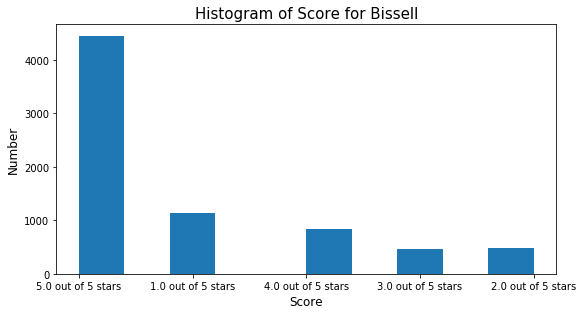

In [10]:
plt.figure(figsize=(8,4))
plt.hist(df['Score'])
plt.tight_layout()
plt.title('Histogram of Score for Bissell',fontsize =15)
plt.xlabel('Score',fontsize =12)
plt.ylabel('Number',fontsize =12)

# LDA modeling

In [11]:
df['Review_content'].head()

0    I am in the process of purchasing this for our...
1    Excellent idea. Worked fantastic on my polishe...
2    I saved up money and was super excited to orde...
3    Wish i wouldn’t of purchased this floor cleane...
4    Okay so I waited a couple of months to try thi...
Name: Review_content, dtype: object

In [12]:
reviews = df['Review_content']

In [13]:
type(reviews)

pandas.core.series.Series

### Raw Data Preprocessing

In [14]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')+ list(string.punctuation)
texts = [[word for word in str(document).lower().split() if word not in stopwords] for document in reviews]
#remove all punctuations
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in texts]

In [15]:
#remove non-english words
words = set(nltk.corpus.words.words())
contents = str(reviews)
contents = " ".join(w for w in nltk.wordpunct_tokenize(contents) if w.lower() in words or not w.isalpha())
contents = contents.split()

In [16]:
#Text Normalization-stemming
from nltk.stem.snowball import SnowballStemmer

snow_stemmer = SnowballStemmer(language='english')
  
#stem of each word
stem_words = []
for w in contents:
    x = snow_stemmer.stem(w)
    stem_words.append(x)
pre_texts = stem_words

### using sklearn

#### Data Preparing

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

tf_vectorizer = CountVectorizer(min_df=5, stop_words=stopwords)
tf = tf_vectorizer.fit_transform(pre_texts)
tf_feature_names = tf_vectorizer.get_feature_names()
X_train, X_test = train_test_split(\
                tf, test_size=0.1, random_state=0)

#### Extract topics

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
# max_iter control the number of iterations 
# evaluate_every determines how often the perplexity is calculated
# n_jobs is the number of parallel threads
lda = LatentDirichletAllocation(n_components=num_topics, \
                                max_iter=30,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(X_train)


iteration: 1 of max_iter: 30, perplexity: 925.0567
iteration: 2 of max_iter: 30, perplexity: 566.3581
iteration: 3 of max_iter: 30, perplexity: 550.7236
iteration: 4 of max_iter: 30, perplexity: 550.1337
iteration: 5 of max_iter: 30, perplexity: 550.1306


In [19]:
num_top_words=20
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    words=[(tf_feature_names[i],'%.2f'%topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('time', '2811.12'), ('mop', '1881.12'), ('much', '1222.12'), ('realli', '1092.12'), ('two', '646.12'), ('look', '534.12'), ('way', '510.12'), ('old', '355.12'), ('unit', '308.12'), ('howev', '283.12'), ('super', '282.12'), ('differ', '277.12'), ('definit', '275.12'), ('filter', '271.12'), ('big', '264.12'), ('turn', '263.12'), ('replac', '240.12'), ('bad', '236.12'), ('though', '236.12'), ('perfect', '229.12')]


Topic 1:
[('clean', '7228.12'), ('machin', '2012.12'), ('great', '1863.12'), ('dog', '1386.12'), ('hardwood', '743.12'), ('pet', '672.12'), ('wet', '639.12'), ('rug', '586.12'), ('best', '580.12'), ('small', '497.12'), ('wood', '484.12'), ('see', '438.12'), ('put', '409.12'), ('left', '377.12'), ('wish', '370.12'), ('alway', '322.12'), ('room', '315.12'), ('light', '294.12'), ('price', '275.12'), ('remov', '273.12')]


Topic 2:
[('use', '4298.12'), ('easi', '1753.12'), ('job', '956.12'), ('hard', '876.12'), ('littl', '722.12'), ('day', '612.12'), ('amaz', '597.12'),

In [20]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 12})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=10)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=18)
    plt.show()

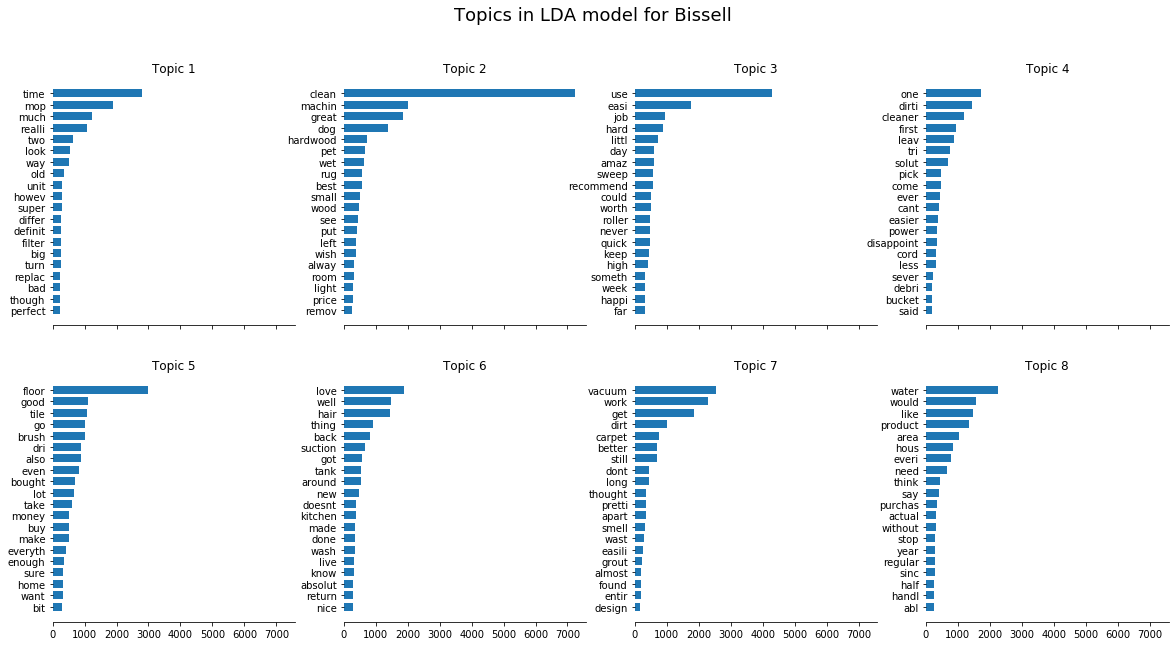

In [21]:
for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [tf_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]


plot_top_words(lda, tf_feature_names, num_top_words, "Topics in LDA model for Bissell")

In [22]:
topic_n = []
word_dict = []
for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[: -num_top_words - 1 : -1]
        top_features = [tf_feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        topic_n.append("Topic %d" % (topic_idx+1))
        word_dict.append(top_features)

tw = pd.DataFrame(word_dict,index = topic_n)
tw
import dataframe_image as dfi
dfi.export(tw,"Bissell_1.png")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,time,mop,much,realli,two,look,way,old,unit,howev,super,differ,definit,filter,big,turn,replac,bad,though,perfect
Topic 2,clean,machin,great,dog,hardwood,pet,wet,rug,best,small,wood,see,put,left,wish,alway,room,light,price,remov
Topic 3,use,easi,job,hard,littl,day,amaz,sweep,recommend,could,worth,roller,never,quick,keep,high,someth,week,happi,far
Topic 4,one,dirti,cleaner,first,leav,tri,solut,pick,come,ever,cant,easier,power,disappoint,cord,less,sever,debri,bucket,said
Topic 5,floor,good,tile,go,brush,dri,also,even,bought,lot,take,money,buy,make,everyth,enough,sure,home,want,bit
Topic 6,love,well,hair,thing,back,suction,got,tank,around,new,doesnt,kitchen,made,done,wash,live,know,absolut,return,nice
Topic 7,vacuum,work,get,dirt,carpet,better,still,dont,long,thought,pretti,apart,smell,wast,easili,grout,almost,found,entir,design
Topic 8,water,would,like,product,area,hous,everi,need,think,say,purchas,actual,without,stop,year,regular,sinc,half,handl,abl


In [23]:
#pip install wordcloud

#### Visualization using wordcloud

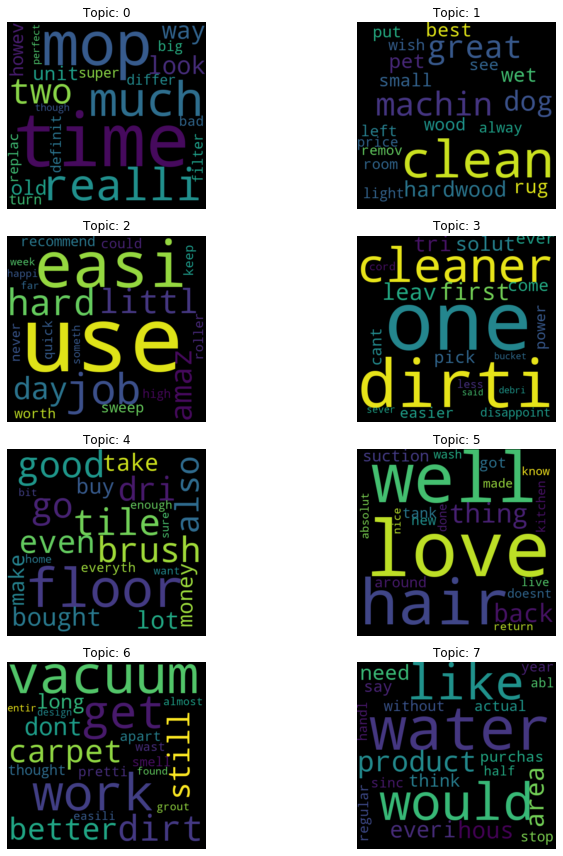

In [24]:
from wordcloud import WordCloud
import math

num_top_words=20
f, axarr = plt.subplots(4, 2, figsize=(12, 12));

for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with two columns (word, weight) for each topic
    
    # create a word:count dictionary
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    
    # generate wordcloud in subplots
    wordcloud = WordCloud(width=480, height=450, margin=0, background_color="black");
    _ = wordcloud.generate_from_frequencies(frequencies=f);
    
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')

plt.tight_layout()
plt.show()

#### Visualization using PyLDAvis

In [25]:
display = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(display)

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### using gensim

#### Turning text to dictionary

In [26]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(24784 unique tokens: ['(cold,', '2', '2800', '3', '4']...)


In [27]:
corpus = [dictionary.doc2bow(text) for text in texts]


#### Extracting Topics

In [28]:
num_topics = 8 
ldamodel = LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)


In [29]:
topics = ldamodel.show_topics()
for topic in topics:
    print(topic)

(0, '0.015*"one" + 0.010*"stopped" + 0.010*"bissell" + 0.009*"months" + 0.007*"bought" + 0.007*"working" + 0.006*"worked" + 0.006*"new" + 0.005*"used" + 0.005*"year"')
(1, '0.010*"bissell" + 0.008*"machine" + 0.006*"would" + 0.006*"crosswave" + 0.006*"get" + 0.005*"back" + 0.005*"first" + 0.005*"one" + 0.005*"product" + 0.005*"time"')
(2, '0.004*"product" + 0.004*"waste" + 0.003*"excellent" + 0.003*"uses," + 0.002*"options" + 0.002*"like." + 0.002*"components" + 0.002*"sq." + 0.002*"quality." + 0.002*"suction"')
(3, '0.005*"use!" + 0.004*"purchase!" + 0.004*"awesome" + 0.004*"advertised." + 0.003*"husky" + 0.003*"moping" + 0.003*"scrubs" + 0.003*"evenly" + 0.003*"game" + 0.003*"sucks."')
(4, '0.020*"clean" + 0.014*"floors" + 0.010*"use" + 0.010*"vacuum" + 0.010*"cleaning" + 0.010*"time" + 0.009*"get" + 0.008*"hair" + 0.007*"would" + 0.007*"mop"')
(5, '0.042*"love" + 0.034*"easy" + 0.029*"great" + 0.024*"floors" + 0.022*"works" + 0.017*"cleaning" + 0.015*"cleans" + 0.014*"clean" + 0.013

In [30]:
word_dict = {};
for i in range(num_topics):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic ' + '{:2d}'.format(i+1)] = [i[0] for i in words]
wd = pd.DataFrame(word_dict)
wd_transposed = wd.T
wd_transposed
dfi.export(wd_transposed,"Bissell_2.png")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,one,stopped,bissell,months,bought,working,worked,new,used,year,buy,purchased,service,started,repair,3,product,another,first,2
Topic 2,bissell,machine,would,crosswave,get,back,first,one,product,time,vacuum,buy,cleaning,much,i'm,unit,pet,it.,like,another
Topic 3,product,waste,excellent,"uses,",options,like.,components,sq.,quality.,suction,needs,"furniture,",pleased.,tool.,catches,places.,needs.,junk,worth.,"while,"
Topic 4,use!,purchase!,awesome,advertised.,husky,moping,scrubs,evenly,game,sucks.,old.,slobber,ago!,pets!,also.,paw,it!!!!,10/10,anyway,changer!
Topic 5,clean,floors,use,vacuum,cleaning,time,get,hair,would,mop,like,floor,water,used,one,much,every,it.,it’s,dirty
Topic 6,love,easy,great,floors,works,cleaning,cleans,clean,use,best,tile,floor,hardwood,one,job,floors.,well,product,hard,it!
Topic 7,water,floor,clean,cleaning,dirty,vacuum,use,machine,brush,like,solution,would,mop,get,wet,hard,really,cleaner,dry,dirt
Topic 8,beware.,expected,"used,",buyer,internal,tineco,hands.,email,$400,"working,",expectations.,lives,delicate,granddaughter,ur,ass,paid.,closed,cross-wave,use)


In [31]:
# coherence score
from gensim.models import CoherenceModel
coherence_model_lda=CoherenceModel(model=ldamodel,texts=texts,dictionary=dictionary,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.5053241766249267


#### Visualization using PyLDAvis

In [32]:
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)


/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/opt/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


### Hyperparameter Tuning - Number of Topics and Alpha

#### (1)Evaluate Topic Model using Perplexity and find the the number of topics

Text(0.5, 0, 'num_topics')

Text(0, 0.5, 'perplexity score')

Text(0.5, 1.0, 'Bissell number of topic - perplexity score')

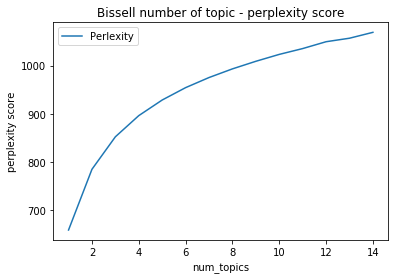

In [38]:

result=[]
for num_topics in range(1,15):
    lda = LatentDirichletAllocation(n_components=num_topics, \
                                learning_method='online', \
                                max_iter=30,verbose=0, n_jobs=1,
                                random_state=0).fit(X_train)
    p=lda.perplexity(X_test)
    result.append([num_topics,p])
    
num_p = pd.DataFrame(result, columns=["num_topics", "Perlexity"])
num_p.plot.line(x='num_topics',y="Perlexity")
plt.xlabel('num_topics')
plt.ylabel('perplexity score')
plt.title('Bissell number of topic - perplexity score')
plt.show()

A lower perplexity score indicates better generalization performance

#### (2)compute coherence value at various values of alpha and num_topics

In [39]:
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values


In [40]:
# build models accross a range of num_topics and alpha
num_topics_range= range(1,15)
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=dictionary,corpus=corpus,texts=texts,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)


In [41]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,1,0.341074
1,0.01,2,0.344416
2,0.01,3,0.353062
3,0.01,4,0.359839
4,0.01,5,0.333621
5,0.01,6,0.353534
6,0.01,7,0.345328
7,0.01,8,0.347779
8,0.01,9,0.336359
9,0.01,10,0.349614


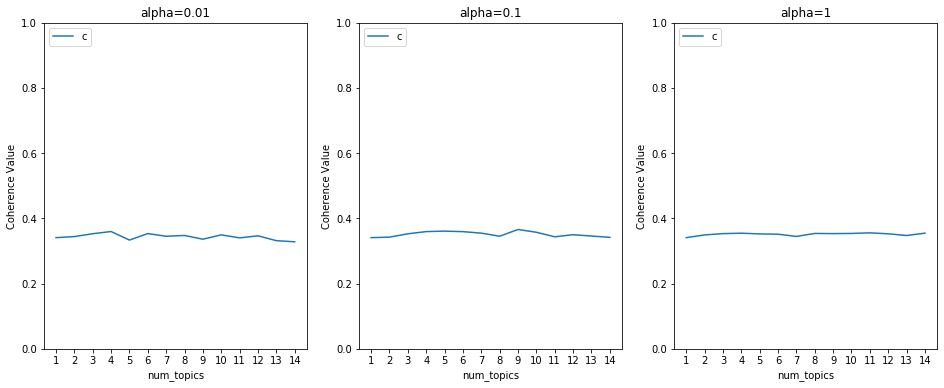

In [42]:
# plot the relationship between alpha, number of topics and coherence value
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df,alpha_range,num_topics_range)